In [1]:
# import pandas as pd
# import numpy as np
# import tensorflow as tf

# # (x_train, _), (x_test, _) = mnist.load_data()
# train_samples = pd.read_csv('utils/path_data.csv',dtype=object, header=None, names = ['imagePath', 'label'])
# train_samples['imagePath'] = 'wikiart/' + train_samples['imagePath'].astype(str)
# train_samples


# if tf.test.gpu_device_name(): 
#     print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

# else:
#    print("Please install GPU version of TF")

# train_samples.shape

Default GPU Device:/device:GPU:0


(13346, 2)

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf

## labels to remove
removeLabels = ['1','2','6','10','16','18','25']

train_samples = pd.read_csv('utils/style_train.csv',dtype=object, header=None, names = ['imagePath', 'label'])
# train_samples['imagePath'] = 'wikiart/' + train_samples['imagePath'].astype(str)
train_samples = train_samples.loc[~train_samples["label"].isin(removeLabels)]
train_samples = train_samples[:35000]

val_samples = pd.read_csv('utils/style_val.csv',dtype=object, header=None, names = ['imagePath', 'label'])
# val_samples['imagePath'] = 'wikiart/' + val_samples['imagePath'].astype(str)
val_samples = val_samples.loc[~val_samples["label"].isin (removeLabels)]
val_samples = val_samples[:15000]

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
   print("Please install GPU version of TF")

print(train_samples.shape)
print(val_samples.shape)
# print("Train Labels: ", train_samples.label.value_counts())
# print("Val Labels: ", val_samples.label.value_counts())

Default GPU Device:/device:GPU:0
(35000, 2)
(15000, 2)


In [2]:
# from PIL import Image

# def preprocess_img(img_path):
#     img = Image.open(img_path).convert('RGB') ## RGB for 3 channels, L for grayscale
#     size = 224, 224
#     # img.thumbnail(size,Image.ANTIALIAS)
#     img = img.resize(size, Image.ANTIALIAS)
#     img = np.asarray(img)
#     img = img.astype('float32')/255.
#     # print(img.shape)
#     # print(img)
#     return img

# def load_data(samples):
#     X_train, X_test = [], [] 
    
#     for index, row in samples.iterrows():   
#         try:
#             img = preprocess_img(row.imagePath) 
#             if((int(row.trainTest) % 2) == 0):
#                 # X_train.append(img)
#                 continue
#             else:
#                 X_test.append(img)

#             print("Index:", index)
#         except:
#             print("image not found: ", row.imagePath)  


#     # return np.array(X_train), np.array(X_test)
#     return np.array(X_test)

# print("Loading sample files...")
# # X_train, X_test = load_data(train_samples)
# X_test = load_data(train_samples[:20])  

# # print("(>^.^)> X_train shape:", X_train.shape)
# print("(>^.^)> X_test shape:", X_test.shape)

Loading sample files...
Index: 3
Index: 4
Index: 5


C:\Users\Abdi\AppData\Local\Temp\ipykernel_11872\4093644144.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(size, Image.ANTIALIAS)


Index: 7
Index: 9
Index: 10
Index: 13
Index: 14
Index: 17
Index: 18
Index: 19
(>^.^)> X_test shape: (11, 224, 224, 3)


In [2]:
# from sklearn.model_selection import train_test_split
# train_samples, val_samples = train_test_split(train_samples, test_size= 0.25, random_state = 42)
# # test_samples, val_samples = train_test_split(val_samples, test_size= 0.5, random_state = 42)
# print(train_samples.shape)
# print(val_samples.shape)
# # print(test_samples.shape)
# train_samples

(10009, 2)
(3337, 2)


,imagePath,trainTest
8986,wikiart/Art_Nouveau_Modern/nicholas-roerich_gi...,14
4351,wikiart/Impressionism/claude-monet_river-scene...,4
3033,wikiart/Realism/john-singer-sargent_venetian-b...,11
12627,wikiart/Naive_Art_Primitivism/marc-chagall_pro...,12
10212,wikiart/Realism/ilya-repin_in-the-township-boa...,8
...,...,...
11964,wikiart/Baroque/rembrandt_portrait-of-an-old-m...,20
5191,wikiart/Post_Impressionism/vincent-van-gogh_po...,22
5390,wikiart/Post_Impressionism/pyotr-konchalovsky_...,18
860,wikiart/Realism/pyotr-konchalovsky_sunny-day-t...,18


## Prepare Data-Generator

In [7]:
from tensorflow import keras
from keras.utils import np_utils
# from keras import utils as np_utils
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import cv2

# ## Data Augmentation
# def data_augmentation(img, rate = 0.5):
    
#     ## Flip Horizontal
#     if np.random.rand() < rate:
#         img = img[:, ::-1]
        
#     ## Flip Vertical
#     if np.random.rand() < rate:
#         img = img[::-1, :]
    
#     return img


def preprocess_img(img_path):
    img = Image.open(img_path).convert('RGB') ## RGB for 3 channels, L for grayscale
    size = 224, 224
    img = img.resize(size, Image.Resampling.LANCZOS)
    img = np.asarray(img)
    img = img.astype('float32')/255.
    # print(img.shape)
    # print(img)
    return img

class Data_Generator(keras.utils.Sequence):
    def __init__(self, samples, batch_size = 32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        #self.labels = labels
        self.samples = samples
        # self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.samples))
        if self.shuffle == False:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.samples) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
#         print("indexes: ", indexes)
        samples_temp = pd.DataFrame([self.samples.iloc[k] for k in indexes])

        # Generate data
        X_train = []
        for index, row in samples_temp.iterrows():    
            try:                 
                img = preprocess_img(row.imagePath)  
                X_train.append(img)
            except:
                continue
            # y_train.append(row.label)   

        X_train = np.array(X_train)
        X_train = np.reshape(X_train, (X_train.shape[0], 224, 224, 3)) 
        
        return X_train, X_train

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import  ModelCheckpoint

input = layers.Input(shape=(224, 224, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same", name = 'encoder')(x)

# Decoder
x = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
model = Model(input, x)
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 256)       2951

In [9]:
batch_size = 32
# # Checkpoint
filepath = "_weights.hdf5"
minloss = ModelCheckpoint("minloss_" + filepath, monitor = 'val_loss', verbose = 0, 
                             save_best_only = True, mode = 'min')
                             
training_batch_generator = Data_Generator(train_samples, batch_size)
validation_batch_generator = Data_Generator(val_samples, batch_size)

tf.autograph.experimental.do_not_convert
history = model.fit(training_batch_generator,
                   steps_per_epoch = int(len(train_samples) // batch_size),
                   epochs = 20,
                   verbose = 1,
                   callbacks=[minloss],
                   validation_data = validation_batch_generator,
                   validation_steps = int(len(val_samples) // batch_size))

Epoch 1/20
1093/1093 [==============================] - 863s 784ms/step - loss: 0.0117 - val_loss: 0.0065
Epoch 2/20
1093/1093 [==============================] - 859s 785ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 3/20
1093/1093 [==============================] - 859s 785ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 4/20
1093/1093 [==============================] - 860s 787ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 5/20
1093/1093 [==============================] - 815s 745ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 6/20
1093/1093 [==============================] - 798s 730ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 7/20
1093/1093 [==============================] - 797s 729ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 8/20
1093/1093 [==============================] - 796s 728ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 9/20
1093/1093 [==============================] - 801s 733ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 10/20
1093/1093 [=======================

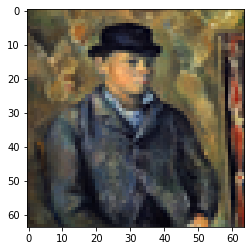

In [14]:
# from matplotlib import pyplot as plt
# plt.imshow(X_train[2], interpolation='nearest')
# plt.show()

In [10]:
with open('autoencoder.json', 'w') as f:
    f.write(model.to_json())

1/1 [==============================] - 0s 18ms/step


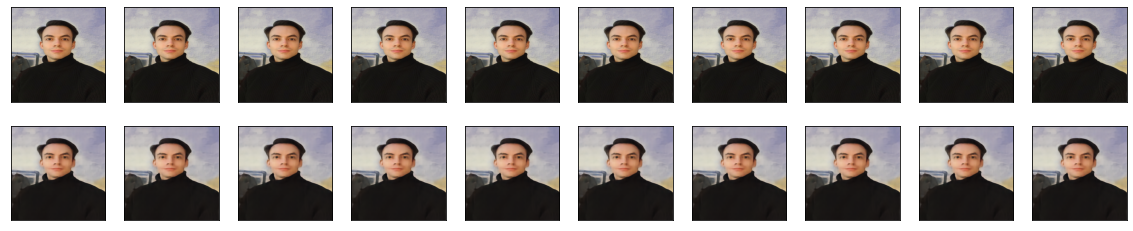

In [24]:
from matplotlib import pyplot as plt
    

X_test = []

for i in val_samples[:11].imagePath:
    i = "examples/luis_a.jpg"
    img = preprocess_img(i)
    X_test.append(img)

decoded_imgs = model.predict(np.array(X_test))

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(224, 224, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(224, 224, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 [==============================] - 0s 18ms/step


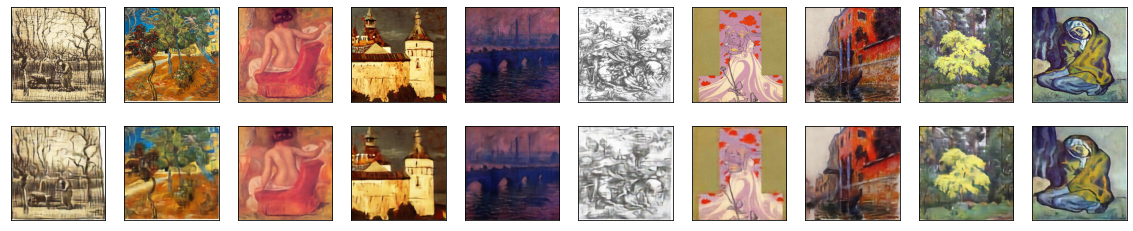

In [ ]:
from matplotlib import pyplot as plt
    

X_test = []
for i in val_samples[:11].imagePath:
    img = preprocess_img(i)
    X_test.append(img)

decoded_imgs = model.predict(np.array(X_test))

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(224, 224, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(224, 224, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

168/168 [==============================] - 2s 10ms/step


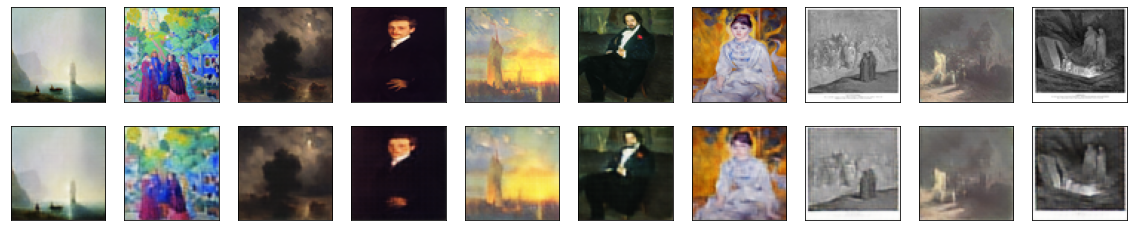

In [5]:
from matplotlib import pyplot as plt
from tensorflow.keras.models import model_from_json
# Model reconstruction from JSON file
with open('autoencoder_original.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights("autoencoder_weights.hdf5")
model.compile(optimizer="adam", loss="binary_crossentropy")

decoded_imgs = model.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
from tensorflow.keras.models import model_from_json
# Model reconstruction from JSON file
with open('autoencoder.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights("autoencoder_weights.hdf5")
model.compile(optimizer="adam", loss="binary_crossentropy")
encoder = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('encoder').output)

X_test[0].shape
test = np.expand_dims(X_test[0], axis = 0)
encoder.predict(test)


1/1 [==============================] - 0s 99ms/step


array([[[[0.22044286, 0.37919927, 0.32394308, ..., 0.49234676,
          0.16843951, 0.25003046],
         [0.22230722, 0.2572061 , 0.15789622, ..., 0.26584426,
          0.18633544, 0.26516828],
         [0.29778296, 0.23320603, 0.03978879, ..., 0.2273514 ,
          0.2505763 , 0.12048282],
         ...,
         [0.11063843, 0.36799493, 0.0946091 , ..., 0.13052668,
          0.10427639, 0.189121  ],
         [0.08395509, 0.32654285, 0.08667782, ..., 0.16898657,
          0.10769597, 0.2153623 ],
         [0.1494011 , 0.3505022 , 0.0842953 , ..., 0.10359006,
          0.11307007, 0.13780011]],

        [[0.23281315, 0.18097551, 0.19588843, ..., 0.46131045,
          0.1803703 , 0.03989146],
         [0.3299997 , 0.1464628 , 0.19701473, ..., 0.21233696,
          0.2588286 , 0.26648402],
         [0.3117375 , 0.09826834, 0.21007596, ..., 0.26898187,
          0.1582832 , 0.28011444],
         ...,
         [0.07252198, 0.16955757, 0.10278101, ..., 0.09040963,
          0.1338937 , 0.2